# Modelo Supervisionado

Este notebook cria um modelo de classificação supervisionada para rotular automáticamente novos comentários feitos na loja de aplicativos.

## Carregando Dependências

In [1]:
import pandas
import warnings
import matplotlib.pyplot as plt

#from google.colab import drive
from wordcloud import WordCloud
from operator import itemgetter

from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

## Configurações

In [2]:
#drive.mount('/content/gdrive')
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 7)
pandas.set_option('display.max_colwidth', -1)

## Codificando Classe Objetivo

In [3]:
def get_label(category):
  if category == 'Elogio':
    return 0
  elif category == 'Funcionalidade':
    return 1
  elif category == 'Instabilidade':
    return 2
  
def get_description(value):
  if value == 0:
    return 'Elogio'
  elif value == 1:
    return 'Funcionalidade'
  elif value == 2:
    return 'Instabilidade'

rfn_df = pandas.read_csv('refined', sep=',')
rfn_df['Label'] = rfn_df.Category.apply(get_label)
rfn_df.head()

,Author,Date,Review,Rating,Likes,Dislikes,Platform,Device,Size,Cluster,Category,Label
0,Fábio F. de Oliveira,2019-06-20 18:06:37,nao funciona,2,NaN,NaN,Android,Galaxy J4+ (j4primelte),12,1,Instabilidade,2
1,Davidson P Sena,2019-06-20 17:53:10,editei a nota pois voces corrigiram o erro que tinha no aplicativo agora a unica coisa que esta incomodando ainda e a lentidao no aguardo e obrigado,4,9.0,NaN,Android,Galaxy Note9 (crownqltechn),150,1,Elogio,0
2,Jackeline Mos,2019-06-20 17:47:59,trava muito nao gostei,1,NaN,NaN,Android,LG K10 (2017) (mlv5),23,0,Instabilidade,2
3,Amanda Caroline,2019-06-20 17:46:49,nao consigo entrar saiu da tela de faturas do nada e quando voltei pedia meu cpf pra ver se tinha cadastro demora a carregar e quando carrega diz que nao conseguiram acessar minhas informacoes,1,NaN,NaN,Android,LG Q6 (mh),194,2,Instabilidade,2
4,VIVEREMSALVADOR VIVER,2019-06-20 17:35:28,otimo,5,NaN,NaN,Android,LG Q6 (mh),5,1,Elogio,0


## Distribuição dos Dados

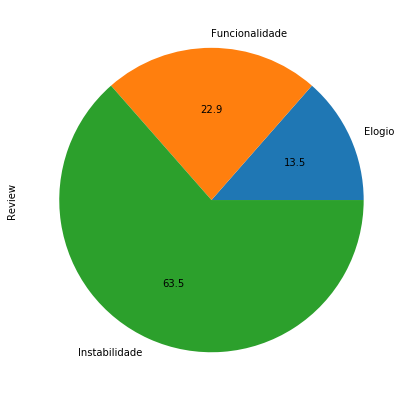

In [4]:
rfn_df.groupby('Category')['Review'].count().plot.pie(autopct='%.1f')

## Score de Avaliação por Classe

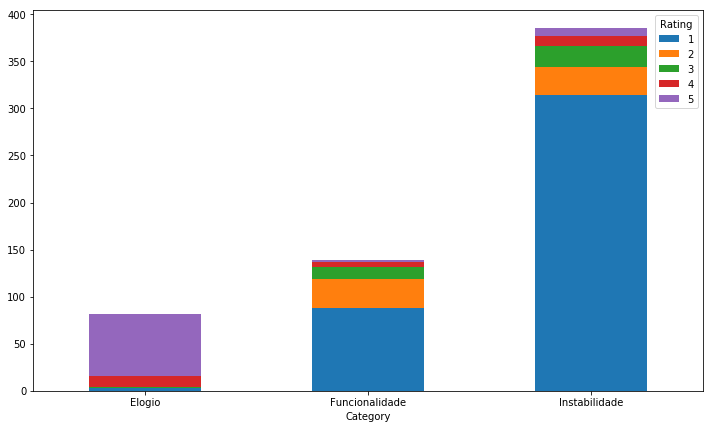

In [5]:
contingency = pandas.crosstab(rfn_df.Category, rfn_df.Rating)
contingency.plot.bar(stacked=True, rot=0)

## Vetorizando Dados

In [6]:
vectorizer = TfidfVectorizer(token_pattern='(?u)\\b\\w\\w+\\b', norm='l2', lowercase=True, use_idf=True, max_features=1700)
model_vectorizer = vectorizer.fit(rfn_df.Review.values)
features = model_vectorizer.transform(rfn_df.Review.values)
features.shape

(606, 1700)

In [7]:
# Descomentar quando desejar salvar modelo retreinado.
# joblib.dump(model_vectorizer, '/content/gdrive/My Drive/dojo-appstores/models/vectorizer.pkl')

## Split - Treino e Teste

Vamos treinar o modelo com 70% dos dados e validar com 30%. Isso é necessário para medir a capacidade de generalização do modelo.

In [8]:
x_train, x_test, y_train, y_test = train_test_split(features, rfn_df.Label.values, test_size=0.2, random_state=42)

classifier = LogisticRegression(n_jobs=1, class_weight='balanced', solver='lbfgs', max_iter=30, multi_class='ovr')
model = classifier.fit(x_train, y_train)

predicted = model.predict(x_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        21
           1       0.92      0.79      0.85        29
           2       0.89      0.94      0.92        72

   micro avg       0.90      0.90      0.90       122
   macro avg       0.91      0.88      0.89       122
weighted avg       0.90      0.90      0.90       122



## Treinar e Aferir o Modelo

O modelo teve um bom resultado, com acurácia de 90% e boa relação precision x recall. Vamos tomar esse modelo como um baseline e considerar que estas aferições podem ser melhoradas com modelos mais robustos. Resultados melhores podem ser obtidos com através de um modelo Convolution1D com Pooling e regulariação por Dropout

## Salvando Modelo

In [9]:
# Descomentar quando desejar salvar modelo retreinado.
# joblib.dump(model, '/content/gdrive/My Drive/dojo-appstores/models/review_model.pkl')

## Nuvem de Palavras por Classe

70 coeficientes mais importantes:  [1038 1105 1104  237  654  969 1089  711 1609 1125 1622  765  592 1584
  667  741   93  228 1657  108 1305 1468  101  231  487  184 1472 1336
 1162  191  313  960  225  816   66 1473 1227 1073  128  962  812  565
   97  408  569 1247  268  299  122 1057 1655 1207 1307 1156 1598   90
  238  897  283  212 1563  294 1496 1430 1055  517  473  870 1161 1509]
idx_to_word {1045: 'nao', 740: 'funciona', 565: 'editei', 1076: 'nota', 1197: 'pois', 1687: 'voces', 408: 'corrigiram', 620: 'erro', 1290: 'que', 1563: 'tinha', 1070: 'no', 150: 'aplicativo', 93: 'agora', 1617: 'unica', 323: 'coisa', 631: 'esta', 812: 'incomodando', 101: 'ainda', 894: 'lentidao', 97: 'aguardo', 1083: 'obrigado', 1598: 'trava', 1038: 'muito', 768: 'gostei', 369: 'consigo', 606: 'entrar', 1423: 'saiu', 423: 'da', 1532: 'tela', 436: 'de', 684: 'faturas', 552: 'do', 1043: 'nada', 1287: 'quando', 1691: 'voltei', 1142: 'pedia', 989: 'meu', 410: 'cpf', 1220: 'pra', 1656: 'ver', 1431: 'se', 26

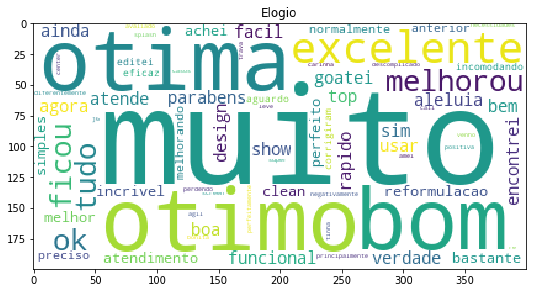

In [12]:
mw = 70
fig = plt.figure(figsize = (30, 15))
sw = ['da', 'de', 'do', 'no', 'a', 'o', 'ok', 'sim', 'se', 'que', 'pra']

klasses = [0]#, 1, 2]
for k in klasses:
  title = get_description(k) # chama a função pra converter para classificação:elogio, funcionabilidade
  coefficients = model.coef_[k]
  keys = coefficients.argsort()[::-1][:mw]
  
  print('70 coeficientes mais importantes: ', keys)  
    
  idx_to_word = {v: k for k, v in vectorizer.vocabulary_.items()}# ligando as 70 palavras com a tradução do vocab.

  print('idx_to_word', idx_to_word)

  words = list(itemgetter(*keys)(idx_to_word)) # ele retorna oq há na posição de keys, em forma de vetor.

  dictionary = {}
  d = 300
  for w in words:
    dictionary[w] = d
    d = d - 3

  wc = WordCloud(background_color='white', max_words=mw, relative_scaling=0.1, normalize_plurals=True, stopwords=sw)
  image = wc.generate_from_frequencies(dictionary) ## esse comando coloca a frequencia das palavras do dictionary
  
  ax = fig.add_subplot(1, 3, (k+1))
  plt.imshow(image)
  ax.set_title(title)

In [11]:
print( words)

['muito', 'otimo', 'otima', 'bom', 'excelente', 'melhorou', 'ok', 'ficou', 'tudo', 'parabens', 'usar', 'goatei', 'encontrei', 'top', 'facil', 'funcional', 'agora', 'bem', 'verdade', 'aleluia', 'rapido', 'show', 'ainda', 'boa', 'design', 'atende', 'sim', 'reformulacao', 'perfeito', 'atendimento', 'clean', 'melhor', 'bastante', 'incrivel', 'achei', 'simples', 'preciso', 'normalmente', 'anterior', 'melhorando', 'incomodando', 'editei', 'aguardo', 'corrigiram', 'eficaz', 'principalmente', 'call', 'center', 'amei', 'negativamente', 'venho', 'positiva', 're', 'perdendo', 'trava', 'agil', 'bonita', 'leve', 'carinha', 'avaliado', 'tinha', 'casos', 'splash', 'screen', 'necessidades', 'diferentemente', 'descomplicado', 'j6', 'perfeitamente', 'super']
